# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *

import time

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [14]:
# ## deJPEG 
# fname = 'data/denoising/selfie.jpg'

## denoising
fname = 'data/noisy_images/'

In [91]:
def run(image, image_name, sigma, num_iter=3000):
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    # Load Image
    img_pil = crop_image(get_image(fname + image + "_sigma=" + sigma + "_gt.png", imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil = crop_image(get_image(fname + image + "_sigma=" + sigma + "_" + image_name + ".png", imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    # img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6)
    
    
    
    # Set Up
    INPUT = 'noise' # 'meshgrid'
    pad = 'reflection'
    OPT_OVER = 'net' # 'net,input'

    reg_noise_std = 1./30. # set to 1./20. for sigma=50
    LR = 0.01

    OPTIMIZER='adam' # 'LBFGS'
    show_every = 2000
    exp_weight=0.99



    input_depth = 32 
    figsize = 4 


    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

    # Compute number of parameters
    s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
    print ('Number of params: %d' % s)

    # Loss
    mse = torch.nn.MSELoss().type(dtype)

    img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
    
    
    
    # Optimize
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    out_avg = None
    last_net = None
    psrn_noisy_last = 0

    i = 0
 

    def closure():

        global i, out_avg, psrn_noisy_last, last_net, net_input

        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        out = net(net_input)

        # Smoothing
        if out_avg is None:
            out_avg = out.detach()
        else:
            out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

        total_loss = mse(out, img_noisy_torch)
        total_loss.backward()


        psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
        psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
        psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 

        # Note that we do not have GT for the "snail" example
        # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
        if  PLOT and i % show_every == 0:
            out_np = torch_to_np(out)
            plot_image_grid([np.clip(out_np, 0, 1), 
                             np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)



        # Backtracking
        if i % show_every:
            if psrn_noisy - psrn_noisy_last < -5: 
                print('Falling back to previous checkpoint.')

                for new_param, net_param in zip(last_net, net.parameters()):
                    net_param.data.copy_(new_param.cuda())

                return total_loss*0
            else:
                last_net = [x.detach().cpu() for x in net.parameters()]
                psrn_noisy_last = psrn_noisy

        i += 1

        return total_loss.item(), psrn_noisy.item(), psrn_gt.item(), psrn_gt_sm.item()

    p = get_params(OPT_OVER, net, net_input)
    start = time.time()

    total_loss, total_psnr_noisy, total_psnr_gt, total_psnr_gt_sm = optimize(OPTIMIZER, p, closure, LR, num_iter)

#     print("Running %d iteration took %f minutes" % (num_iter, ((time.time() - start) / 60)))

    out_np = torch_to_np(net(net_input))
    q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);
    q = plot_image_grid([np.clip(out_np, 0, 1), img_noisy_np], factor=13)
    
    return total_loss, total_psnr_noisy, total_psnr_gt, total_psnr_gt_sm

In [ ]:
import skimage.io as io
from numpy import moveaxis

def run_simple(image, image_name, sigma, num_iter=3000):
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    # Load Image
    img_pil = crop_image(get_image(fname + image + "_sigma=" + sigma + "_gt.png", imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil = crop_image(get_image(fname + image + "_sigma=" + sigma + "_" + image_name + ".png", imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    # img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6)
    
    
    
    # Set Up
    INPUT = 'noise' # 'meshgrid'
    pad = 'reflection'
    OPT_OVER = 'net' # 'net,input'

    reg_noise_std = 1./30. # set to 1./20. for sigma=50
    LR = 0.01

    OPTIMIZER='adam' # 'LBFGS'
    show_every = 2000
    exp_weight=0.99



    input_depth = 32 
    figsize = 4 


    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

    # Compute number of parameters
    s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
    print ('Number of params: %d' % s)

    # Loss
    mse = torch.nn.MSELoss().type(dtype)

    img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
    
    
    
    # Optimize
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    out_avg = None
    last_net = None
    psrn_noisy_last = 0

    i = 0
 

    def closure():

        global i, out_avg, psrn_noisy_last, last_net, net_input

        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        out = net(net_input)

        # Smoothing
        if out_avg is None:
            out_avg = out.detach()
        else:
            out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

        total_loss = mse(out, img_noisy_torch)
        total_loss.backward()


        psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
        psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
        psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 

        # Note that we do not have GT for the "snail" example
        # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
        if  PLOT and (i+1) % show_every == 0:
            out_np = torch_to_np(out)
            io.imsave('./results/sample outputs/' + image + '_' + image_name + '_' + sigma + '_' + str(i) + '.png', moveaxis(out_np, 0, 2))
            plot_image_grid([np.clip(out_np, 0, 1), 
                             np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)



        # Backtracking
        if i % show_every:
            if psrn_noisy - psrn_noisy_last < -5: 
                print('Falling back to previous checkpoint.')

                for new_param, net_param in zip(last_net, net.parameters()):
                    net_param.data.copy_(new_param.cuda())

                return total_loss*0
            else:
                last_net = [x.detach().cpu() for x in net.parameters()]
                psrn_noisy_last = psrn_noisy

        i += 1

        return total_loss.item(), psrn_noisy.item(), psrn_gt.item(), psrn_gt_sm.item()

    p = get_params(OPT_OVER, net, net_input)
    start = time.time()

    total_loss, total_psnr_noisy, total_psnr_gt, total_psnr_gt_sm = optimize(OPTIMIZER, p, closure, LR, num_iter)

#     print("Running %d iteration took %f minutes" % (num_iter, ((time.time() - start) / 60)))

    out_np = torch_to_np(net(net_input))
    q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);
    q = plot_image_grid([np.clip(out_np, 0, 1), img_noisy_np], factor=13)
    
    return total_loss, total_psnr_noisy, total_psnr_gt, total_psnr_gt_sm


images = ['0', '1', '2']
image_names = ['noisy', 'deconv', 'neural', 'deconv_neural', 'Gaussian_filt', 'Median_filt', 'bilateral']
sigmas = ['0.01', '0.02', '0.05']
num_iter = 6000

start = time.time()

for i1 in range(len(images)):
    for i2 in range(len(image_names)):
        for i3 in range(len(sigmas)):
            run_simple(images[i1], image_names[i2], sigmas[i3], num_iter)

total_time = (time.time() - start)/3600

print("Model runs for %f hours" % total_time)

In [8]:
images = ['0', '1', '2']
image_names = ['noisy', 'deconv', 'neural', 'deconv_neural', 'Gaussian_filt', 'Median_filt', 'bilateral']
sigmas = ['0.01', '0.02', '0.05']
num_iter = 6000

total_loss = np.empty((len(images), len(image_names), len(sigmas)), dtype=object)
total_psnr_noisy = np.empty((len(images), len(image_names), len(sigmas)), dtype=object)
total_psnr_gt = np.empty((len(images), len(image_names), len(sigmas)), dtype=object)
total_psnr_gt_sm = np.empty((len(images), len(image_names), len(sigmas)), dtype=object)

start = time.time()

for i1 in range(len(images)):
    for i2 in range(len(image_names)):
        for i3 in range(len(sigmas)):
            loss, psnr_noisy, psnr_gt, psnr_gt_sm = run(images[i1], image_names[i2], sigmas[i3], num_iter)
            total_loss[i1][i2][i3] = np.array(loss)
            total_psnr_noisy[i1][i2][i3] = np.array(psnr_noisy)
            total_psnr_gt[i1][i2][i3] = np.array(psnr_gt)
            total_psnr_gt_sm[i1][i2][i3] = np.array(psnr_gt_sm)

total_time = (time.time() - start)/3600

print("Model runs for %f hours" % total_time)

## Save the data

In [93]:
np.save("./data/results/total_loss", total_loss)
np.save("./data/results/total_psnr_noisy", total_psnr_noisy)
np.save("./data/results/total_psnr_gt", total_psnr_gt)
np.save("./data/results/total_psnr_gt_sm", total_psnr_gt_sm)

## Calculate Initial PSNRs

In [25]:
import csv

images = ['0', '1', '2']
image_names = ['noisy', 'deconv', 'neural', 'deconv_neural', 'Gaussian_filt', 'Median_filt', 'bilateral']
sigmas = ['0.01', '0.02', '0.05']

initial_psnr = np.empty((len(images), len(image_names), len(sigmas)), dtype=float)

def calc_psnr(image, image_name, sigma):
    # Load Image
    img_pil = crop_image(get_image(fname + image + "_sigma=" + sigma + "_gt.png", imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil = crop_image(get_image(fname + image + "_sigma=" + sigma + "_" + image_name + ".png", imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    psnr = compare_psnr(img_np, img_noisy_np)
    
    return psnr

with open('./results/tables/initial_psnr_2.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    
    writer.writerow(['image', 'input names', 'sigma', 'psnr'])

    # find initial psnr
    for i1 in range(len(images)):
        for i2 in range(len(image_names)):
            for i3 in range(len(sigmas)):
                psnr = calc_psnr(images[i1], image_names[i2], sigmas[i3])
                writer.writerow([images[i1], image_names[i2], sigmas[i3], psnr])
                initial_psnr[i1][i2][i3] = psnr

## Calculate best-fit and max

In [94]:
# #define data
# x = np.array(list(range(len(total_psnr_gt_sm[0][0][0]))))

# #find line of best fit
# a, b, c = np.polyfit(x, total_psnr_gt_sm[0][0][0], 2)

# #add points to plot
# plt.scatter(x, total_psnr_gt_sm[0][0][0])

# nums = [a * np.square(num) + b * num + c for num in x]
# stop_point = nums.index(max(nums))

# #add line of best fit to plot
# plt.plot(x, a * np.square(x) + b * x + c)

In [9]:
def find_max(t):
    #define data
    x = np.array(list(range(len(t))))

#     #find line of best fit
#     a, b, c, d = np.polyfit(x, t, 3)

#     nums = [a * num * num * num + b * num * num + c * num + d for num in x]
    max_y = max(t)
    max_x = list(t).index(max(t))

    return max_x, max_y

In [3]:
# # If interrupted, reload
# total_loss = np.load("./data/results/total_loss.npy", allow_pickle=True)
# total_psnr_noisy = np.load("./data/results/total_psnr_noisy.npy", allow_pickle=True)
# total_psnr_gt = np.load("./data/results/total_psnr_gt.npy", allow_pickle=True)
# total_psnr_gt_sm = np.load("./data/results/total_psnr_gt_sm.npy", allow_pickle=True)

## Generate Plots

The following graphs show the loss and the three psnrs for each input image

In [ ]:
for i1 in range(len(images)):
    for i2 in range(len(image_names)):
        for i3 in range(len(sigmas)):
            title = "Image " + images[i1] + ": " + image_names[i2] + " input (sigma = " + sigmas[i3] + ") with " + str(num_iter) + " iterations"

            plt.plot(total_loss[i1][i2][i3], label = "loss")
            plt.yscale("log")
            plt.title(title)
            plt.legend()
            plt.show()

            plt.plot(total_psnr_noisy[i1][i2][i3], label = "noisy psnr")
            plt.plot(total_psnr_gt[i1][i2][i3], label = "gt psnr")
            plt.plot(total_psnr_gt_sm[i1][i2][i3], label = "gt sm psnr")
            plt.title(title)
            plt.legend()
            plt.show()

In [27]:
images = ['0', '1', '2']
image_names = ['Noisy', 'Wiener', 'NeuralNet', 'Wiener+NeuralNet', 'Gaussian', 'Median', 'Bilateral']
sigmas = ['0.01', '0.02', '0.05']
num_iter = 6000

The following graphs compare the same psnr for different inputs --- this is our task 1

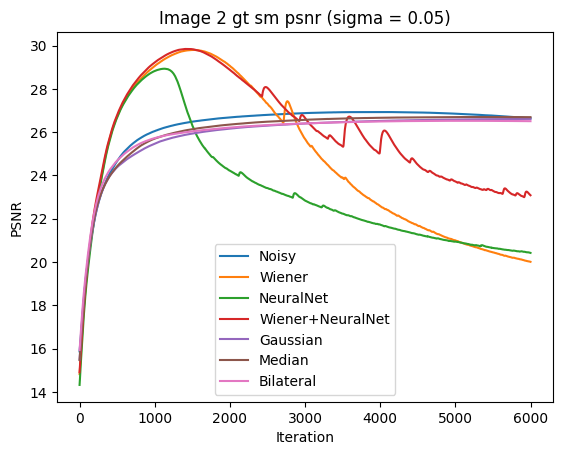

In [32]:
psnrs = ["noisy psnr", "gt psnr", "gt sm psnr"]
psnrs_array = [total_psnr_noisy, total_psnr_gt, total_psnr_gt_sm]

for i1 in range(len(images)):
    for i2 in range(len(psnrs)):
        for i4 in range(len(sigmas)):
            plt.clf()
            title = "Image " + images[i1] + " " + psnrs[i2] + " (sigma = " + sigmas[i4] + ")"
            for i3 in range(len(image_names)):
                plt.plot(psnrs_array[i2][i1][i3][i4], label = image_names[i3])
            plt.title(title)
            plt.xlabel('Iteration')
            plt.ylabel('PSNR')
            plt.legend()
#             plt.show()
            plt.savefig('results/plots/task1/' + title + '.png')

The following graphs compare the same psnr and input for different images --- this is our task 2

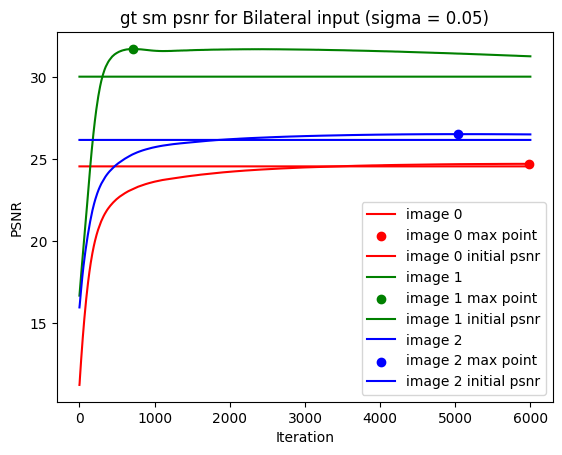

In [33]:
psnrs = ["noisy psnr", "gt psnr", "gt sm psnr"]
psnrs_array = [total_psnr_noisy, total_psnr_gt, total_psnr_gt_sm]
colors = ['red', 'green', 'blue']

for i1 in range(len(psnrs)):
    for i2 in range(len(image_names)):
        for i4 in range(len(sigmas)):
            plt.clf()
            title = psnrs[i1] + " for " + image_names[i2] + " input (sigma = " + sigmas[i4] + ")"
            for i3 in range(len(images)):
                plt.plot(psnrs_array[i1][i3][i2][i4], c = colors[i3], label = "image " + images[i3])
                max_x, max_y = find_max(psnrs_array[i1][i3][i2][i4])
                plt.scatter(max_x, max_y, c = colors[i3], label = "image " + images[i3] + ' max point')
                plt.plot([initial_psnr[i3][i2][i4] for _ in range(num_iter)], c = colors[i3], label = "image " + images[i3] + ' initial psnr')
            plt.title(title)
            plt.xlabel('Iteration')
            plt.ylabel('PSNR')
            plt.legend()
#             plt.show()
            plt.savefig('results/plots/task2/' + title + '.png')

## Generate Tables

### Task 1

In [38]:
for i1 in range(len(images)):
    for i3 in range(len(sigmas)):
        with open('./results/tables/task1/image' + images[i1] + 'sigma' + sigmas[i3] + '.csv', 'w', encoding='UTF8') as f:
            writer = csv.writer(f)

            writer.writerow(['input', 'initial psnr', 'optimal stopping point', 'maximum psnr'])
            
            for i2 in range(len(image_names)):
                max_x, max_y = find_max(total_psnr_gt_sm[i1][i2][i3])
                
                writer.writerow([image_names[i2], initial_psnr[i1][i2][i3], max_x, max_y])

### Task 2

In [39]:
for i3 in range(len(sigmas)):
    with open('./results/tables/task2/sigma' + sigmas[i3] + '.csv', 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        
        writer.writerow(['image', 'optimal stopping point (deconv)', 'maximum psnr (deconv)', 'optimal stopping point (neural)', 'maximum psnr (neural)', 'optimal stopping point (deconv_neural)', 'maximum psnr (deconv_neural)'])
        
        for i1 in range(len(images)):
            line = [images[i1]]
            
            # we only want 'deconv', 'neural', and 'deconv_neural'
            for i2 in [1, 2, 3]:
                max_x, max_y = find_max(total_psnr_gt_sm[i1][i2][i3])
                line.append(max_x)
                line.append(max_y)
            
            writer.writerow(line)